In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from importlib import reload
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import optuna
import pickle
from scipy import stats

from copy import deepcopy

import seaborn as sns
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import datetime

from modules import function

reload(function)


/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_1884/3029951479.py:20: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


<module 'modules.function' from '/Users/junya/program/taxi-fare/scripts/modules/function.py'>

In [2]:
# Get the raw data
train_raw = pd.read_csv("../data/raw/train.csv", nrows=1000000)
test_raw = pd.read_csv("../data/raw/test.csv")


In [3]:
train_raw.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [4]:
def change_dtype(df_raw):
    df = deepcopy(df_raw)
    for col in df.columns:
        if (df[col].dtype == "float64"):
            df[col] = df[col].astype(np.float32)
        elif (df[col].dtype == "int32"):
            df[col] = df[col].astype(np.int32)
    return df


train = change_dtype(train_raw)
test = change_dtype(test_raw)


In [5]:
train.dtypes


key                   object
fare_amount          float32
pickup_datetime       object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        int64
dtype: object

(0.0, 70.0)

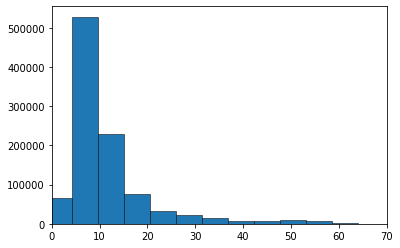

In [6]:
plt.hist(train["fare_amount"], bins=100, linewidth=0.5, edgecolor="black")
plt.xlim(0, 70)


/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_1884/993376624.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_target = train.corr()


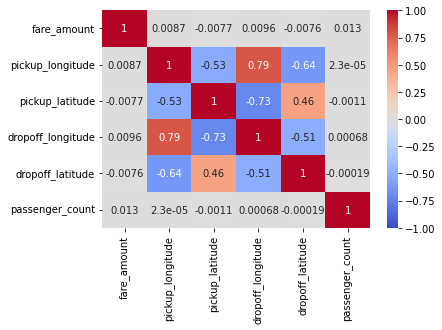

In [7]:
corr_target = train.corr()
sns.heatmap(corr_target, cmap="coolwarm", annot=True, vmin=-1, vmax=1)


(0.0, 10.0)

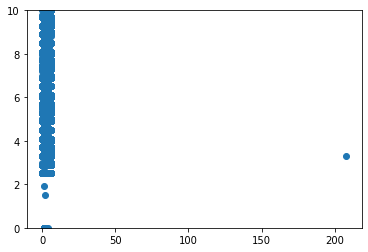

In [8]:
plt.scatter(y=train["fare_amount"], x=train["passenger_count"])
plt.ylim(0, 10)


In [102]:
n_splits = 5


def rmse_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42)
    cv = cross_validate(model, x_train, y_train,
                        scoring="neg_root_mean_squared_error", cv=kf)
    return -cv["test_score"]


class my_cv():
    def __init__(self, model, n_splits=5):
        self.model = model
        self.n_splits = n_splits
        self.rmse_ = 0
        self.result_ = []

    def cv(self, x, y):
        kf = KFold(self.n_splits, shuffle=True, random_state=42)
        result = cross_validate(self.model, x, y,
                                scoring="neg_root_mean_squared_error", cv=kf)
        self.rmse_ = -result["test_score"]
        self.result_ = result


def get_yy(model, x, y):
    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=0.2, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    return y_pred, y_valid


class yy_analize():
    def __init__(self, model, x, y):
        self.model = model
        self.x = x
        self.y = y
        self.y_pred = 0
        self.y_val = 0

    def pred(self, test_size=0.2):
        x_train, x_val, y_train, y_val = train_test_split(
            self.x, self.y, test_size=test_size, random_state=42)
        self.model.fit(x_train, y_train)
        self.y_pred = self.model.predict(x_val)
        self.y_val = y_val


def add_distance(data):
    df = deepcopy(data)
    df["distance_longitude"] = np.abs(
        df["dropoff_longitude"] - df["pickup_longitude"])
    df["distance_latitude"] = np.abs(
        df["dropoff_latitude"] - df["pickup_latitude"])
    df["distance"] = np.sqrt(df["distance_longitude"]
                             ** 2 + df["distance_latitude"]**2)
    return df

def preprocess(data):
    df = deepcopy(data)
    # Fare should be positive
    drop_row = df[df["fare_amount"] <= 0].index
    df = df.drop(drop_row, axis=0)

    # Passenger count should be positive
    drop_row = df[(df["passenger_count"] <= 0) | (df["passenger_count"] > 6)]
    df = df.drop(drop_row.index, axis=0)

    # Location should be in NYC
    loc_col = ["pickup_longitude", "pickup_latitude",
            "dropoff_longitude", "dropoff_latitude"]
    drop_row = []

    for col in loc_col:
        drop_row.extend(df[df[col] == 0].index)
    drop_row = list(set(drop_row))
    df = df.drop(drop_row, axis=0)

    num_col = loc_col + ["fare_amount"]
    drop_row = detect_outliers(df, num_col)
    df = df.drop(drop_row, axis=0)
    
    return df



In [89]:
# Only Ridge

# Change the data type
train = change_dtype(train_raw)
test = change_dtype(test_raw)

# Remove the missing value
train = train.dropna(how="any", axis="rows")

y_train = train["fare_amount"]
x_train = train.drop(["fare_amount"], axis="columns").drop(
    columns=["key", "pickup_datetime"])
x_test = test.drop(columns=["key", "pickup_datetime"])

# Make the pipeline
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1))
ridge_cv = my_cv(ridge)
ridge_cv.cv(x_train, y_train)
print("Mean rmse:", ridge_cv.rmse_.mean())

# Trian score
ridge.fit(x_train, y_train)
y_train_pred = ridge.predict(x_train)
print("Test rmse:", mean_squared_error(y_train, y_train_pred, squared=False))


Mean rmse: 9.82002512104415
Test rmse: 9.820470099730374


In [95]:
# Ridge and Feature Engineering

# Change the data type
train = change_dtype(train_raw)
test = change_dtype(test_raw)

# Remove the missing value
train = train.dropna(how="any", axis="rows")

# Feature Engineering
train = add_distance(train)
test = add_distance(test)

y_train = train["fare_amount"]
x_train = train.drop(["fare_amount"], axis="columns").drop(
    columns=["key", "pickup_datetime"])
x_test = test.drop(columns=["key", "pickup_datetime"])

# Make the pipeline
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1))
ridge_cv = my_cv(ridge)
ridge_cv.cv(x_train, y_train)
print("Mean rmse:", ridge_cv.rmse_.mean())

# Trian score
ridge.fit(x_train, y_train)
y_train_pred = ridge.predict(x_train)
print("Test rmse:", mean_squared_error(y_train, y_train_pred, squared=False))


Mean rmse: 9.819627881877691
Test rmse: 9.819845356403071


In [103]:
# LightGBM and Feature Engineering

# Change the data type
train = change_dtype(train_raw)
test = change_dtype(test_raw)

# Remove the missing value
train = train.dropna(how="any", axis="rows")

# Feature Engineering
train = add_distance(train)
test = add_distance(test)

train = preprocess(train)

y_train = train["fare_amount"]
x_train = train.drop(["fare_amount"], axis="columns").drop(
    columns=["key", "pickup_datetime"])
x_test = test.drop(columns=["key", "pickup_datetime"])

# Cross validation
lgbm_params = {
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    "max_depth": 5,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'random_state': 42,
}

lgbm = lgb.LGBMRegressor(**lgbm_params)
lgbm_cv = my_cv(lgbm)
lgbm_cv.cv(x_train, y_train)
print("Mean rmse:", lgbm_cv.rmse_.mean())

# Trian score
lgbm.fit(x_train, y_train)
y_train_pred = lgbm.predict(x_train)
print("Test rmse:", mean_squared_error(y_train, y_train_pred, squared=False))


Mean rmse: 2.2401357892174696
Test rmse: 2.239339153271521


In [84]:
def detect_outliers(df, num_col):
    """ Get the indecies of outliers based on the IQR method. 
    Note indecies cantain more than the threshold outliers.

    Args:
        df (_type_): _description_
        num_col (_type_): numeric columns

    Returns:
        _type_: indecies of the outliers to drop
    """
    outlier_list = []
    for col in num_col:
        # Calculate the IQR, ignoring the nan
        q1 = np.nanpercentile(df[col], 25)
        q3 = np.nanpercentile(df[col], 75)
        iqr = q3 - q1

        outlier_step = 1.5 * iqr
        outliers = df[(df[col] < q1 - outlier_step) |
                      (df[col] > q3 + outlier_step)].index
        outlier_list.extend(outliers)

    return sorted(list(set(outlier_list)))


Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_longitude', 'distance_latitude',
       'distance'],
      dtype='object')


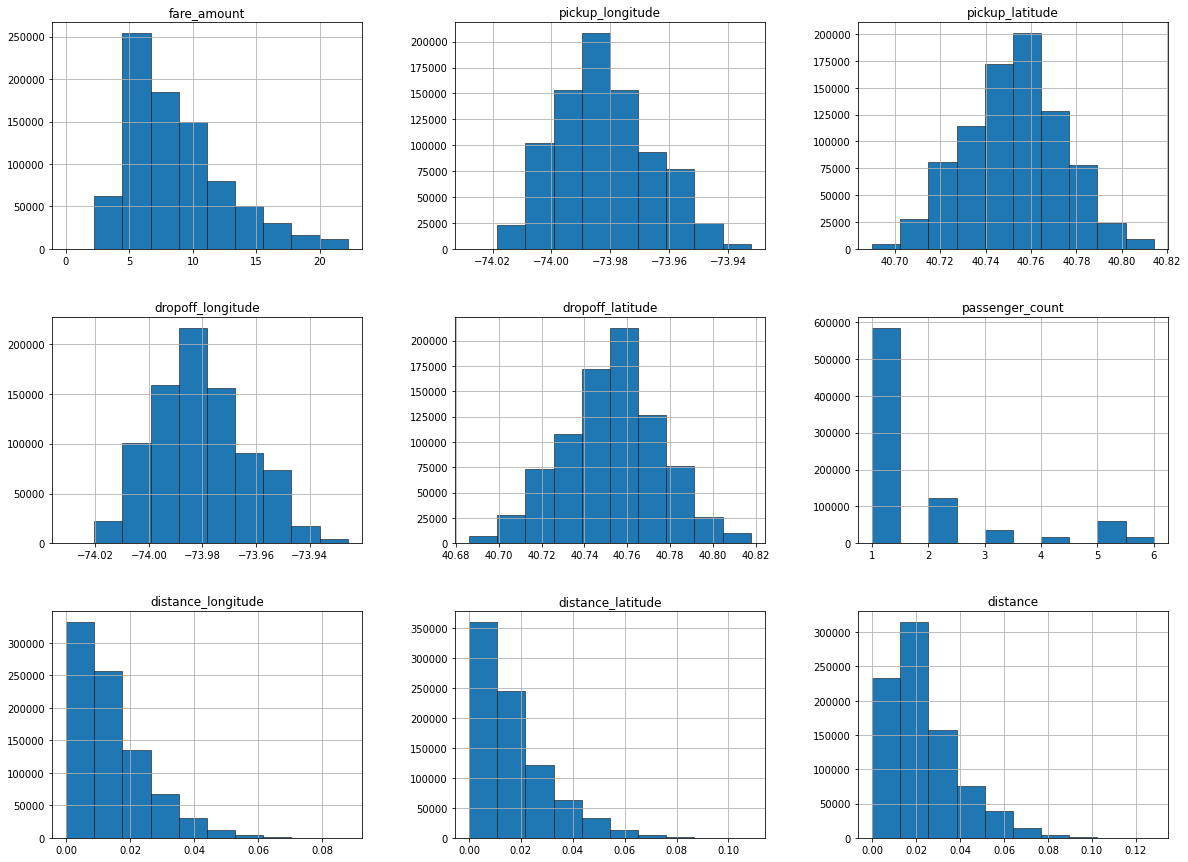

In [101]:
g = df.hist(bins=10, linewidth=0.5, edgecolor="black", figsize=(20, 15))

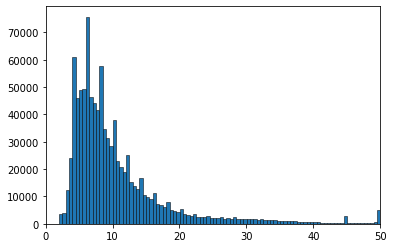

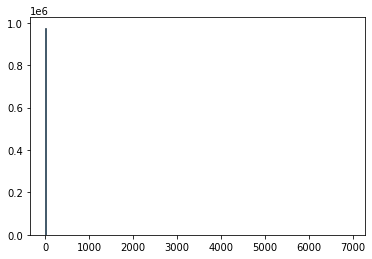

In [75]:
g = plt.hist(df["fare_amount"], bins=1000, linewidth=0.5, edgecolor="black")
plt.xlim(0, 50)



In [20]:
# Prediction
y_pred = lgbm.predict(x_test)
result = pd.read_csv("../data/raw/sample_submission.csv")
result["fare_amount"] = y_pred

dt_now = datetime.datetime.now()
result.to_csv("../data/result/prediction_" +
              dt_now.strftime('%Y%m%d_%H%M%S') + ".csv", index=False)


(0.0, 100.0)

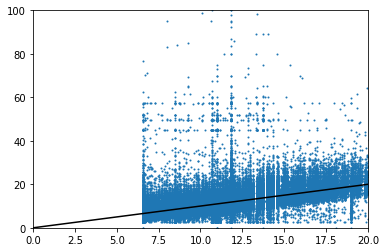

In [11]:
y_pred, y_val = get_yy(lgbm, x_train, y_train)

plt.scatter(y_pred, y_val, s=1)
plt.plot([0, 100], [0, 100], color="black")
plt.xlim(0, 20)
plt.ylim(0, 100)


(0.0, 100.0)

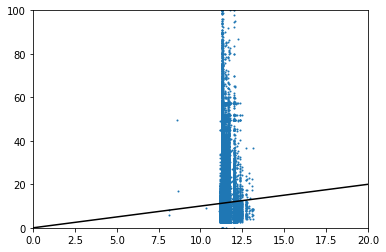

In [83]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1))
y_pred, y_val = get_yy(ridge, x_train, y_train)

plt.scatter(y_pred, y_val, s=1)
plt.plot([0, 100], [0, 100], color="black")
plt.xlim(0, 20)
plt.ylim(0, 100)


AttributeError: 'NoneType' object has no attribute 'model'

In [91]:
# Feature engineering

def add_distance(data):
    df = deepcopy(data)
    df["distance_longitude"] = df["dropoff_longitude"] - df["pickup_longitude"]
    df["distance_latitude"] = df["dropoff_latitude"] - df["pickup_latitude"]
    df["distance"] = np.sqrt(df["distance_longitude"]
                             ** 2 + df["distance_latitude"]**2)
    return df


In [16]:
# Display missing data
nan_total = train_data_raw.isnull().sum().sort_values(ascending=False)
nan_percent = nan_total/len(train_data_raw)
nan_info = pd.concat([nan_total, nan_percent], axis=1,
                     keys=["Total", "Percent"])
nan_info.head(5)


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260


In [17]:
threshold = 0.1
# Sparse column in training data
sparse_col = nan_info[nan_info["Percent"] > threshold].index.values

train_data_raw.drop(columns=sparse_col)


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [18]:
df = train_data_raw


def get_skew_col(df):
    # get columns that have high skewness
    threshold = 0.75

    numeric_col = df.dtypes[df.dtypes != "O"].index

    def get_skewness(series):
        # get skewness in series while dropping nan
        return skew(series.dropna())

    skewness = df[numeric_col].apply(get_skewness)
    skew_col = skewness[skewness > threshold].index

    return skew_col


In [75]:
# Preprocess

# Concatenate data
all_data = pd.concat((train_data_raw.loc[:, 'MSSubClass':'SaleCondition'],
                      test_data_raw.loc[:, 'MSSubClass':'SaleCondition']))

# Drop the sparse columns
all_data = all_data.drop(columns=sparse_col)

# Add one hot features
all_data = pd.get_dummies(all_data)

# Split into train and test
train_data = all_data[:train_data_raw.shape[0]]
test_data = all_data[train_data_raw.shape[0]:]

# Lognize the skew column
skew_col = get_skew_col(train_data)
train_data[skew_col] = np.log1p(train_data[skew_col])
test_data["SalePrice"] = 0
test_data[skew_col] = np.log1p(test_data[skew_col])
test_data = test_data.drop(columns="SalePrice")

# Fill nan with mean
train_data = train_data.fillna(train_data.mean())
test_data = test_data.fillna(test_data.mean())

y_train = np.log1p(train_data_raw["SalePrice"])

# Standardize the features with training features
scaler_x = StandardScaler()
scaler_x.fit(train_data)
x_train = scaler_x.transform(train_data)
x_test = scaler_x.transform(test_data)

# Standardize the target
scaler_y = StandardScaler()
y_train = y_train.values.reshape(-1, 1)
scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)

# Check
assert len(train_data.columns) == len(
    test_data.columns), "The number of columns is different"
assert train_data.isna().sum().sum() == 0 and test_data.isna(
).sum().sum() == 0, "Nan still exists"


/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_77165/3674210404.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[skew_col] = np.log1p(train_data[skew_col])
/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_77165/3674210404.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["SalePrice"] = 0
/var/folders/2g/2p1ts9gx1tz17949_fkbl8bc0000gn/T/ipykernel_77165/3674210404.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [58]:
# Prediction
reg = Ridge(alpha=0.1)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

# Inverse standardization
y_pred = scaler_y.inverse_transform(y_pred)
ridge_pred = np.expm1(y_pred)


In [61]:
# Save prediction
Id = np.array(test_data_raw["Id"]).astype(int)
function.save_kaggle_prediction(Id, y_pred, "Id", "SalePrice")


<Axes: >

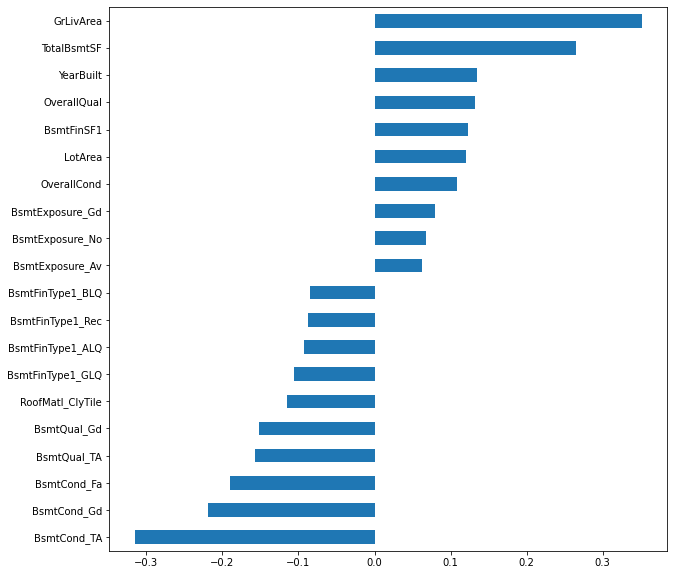

In [34]:
# Get the coefficient of the model
coef = pd.Series(reg.coef_[0], index=train_data.columns)
coef = coef.sort_values()
coef_imp = pd.concat([coef.head(10), coef.tail(10)])

plt.figure(figsize=(10, 10))
coef_imp.plot(kind="barh")


In [59]:
params = {"num_leaves": 10, "max_depth": 5, "objective": "regression",
          "metric": "rmse", "learning_rate": 0.01, "random_state": 42, "n_estimators": 100}
lgbm = lgb.LGBMRegressor(**params)
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred)
lgbm_pred = np.expm1(y_pred)


/Users/junya/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# Emsemble between ridge and lgbm
y_pred = (ridge_pred + lgbm_pred)/2


In [68]:
n_splits = 5


def rmse_cv(model):
    kf = KFold(n_splits, shuffle=True, random_state=42)
    cv = cross_validate(model, x_train, y_train,
                        scoring="neg_root_mean_squared_error", cv=kf)
    return -cv["test_score"]


In [74]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.1))


In [76]:
rmse_cv(ridge)


array([0.12400023, 0.11970249, 0.17290714, 0.13377847, 0.11009432])

In [77]:
rmse_cv(lgbm)


array([0.25083217, 0.2189341 , 0.21750948, 0.24528838, 0.20176161])

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

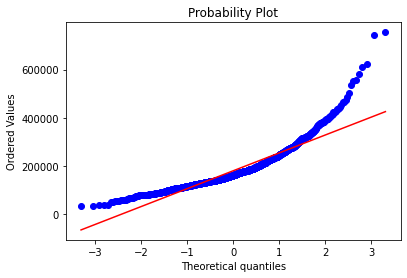

In [64]:
stats.probplot(train_data_raw["SalePrice"], plot=plt)


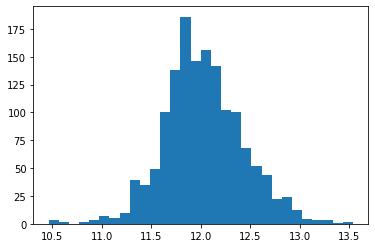

In [63]:
train_data = deepcopy(train_data_raw)
train_data["log_SalePrice"] = np.log(train_data_raw["SalePrice"])

plt.hist(train_data["log_SalePrice"], bins=30)


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.39826223081618867, 12.024050901109383, 0.9953761475636614))

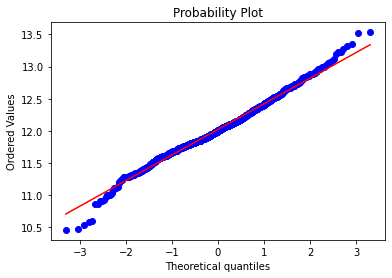

In [66]:
stats.probplot(train_data["log_SalePrice"], plot=plt)


In [106]:
def separate_df(df):
    df_n = df.select_dtypes(include=['int64', 'float64'])
    df_o = df.select_dtypes(include=["O"])
    return df_n, df_o


_, train_data_o = separate_df(train_data_raw)
_, test_data_o = separate_df(test_data_raw)

# for (col1, series1), (col2, series2) in zip(train_data_o.items(), test_data_o.items()):
#     print(col1, len(set(series1)), len(set(series2)))

for col_name in train_data_o.columns:
    one_hot_train = pd.get_dummies(train_data_o[col_name], prefix=col_name)
    one_hot_test = pd.get_dummies(test_data_o[col_name], prefix=col_name)

    if (one_hot_train.shape[1] != one_hot_test.shape[1]):
        print(col_name)


Utilities
Condition2
HouseStyle
RoofMatl
Exterior1st
Exterior2nd
Heating
Electrical
GarageQual
PoolQC
MiscFeature


In [87]:
# 　訓練とテストでスパースな列を抽出
threshold = 0.5

sparse_col = []
for data in [train_data_raw, test_data_raw]:
    for col_name, series in data.items():
        num_nan = series.isna().sum()
        if (num_nan > len(data) * threshold):
            sparse_col.append(col_name)

sparse_col = list(set(sparse_col))


In [108]:
def preprocess(df):

    # 　欠損値の多い列を削除
    df = df.drop(columns=sparse_col)
    df.pop("Id")

    # 　数値データとオブジェクトデータを分ける
    df_n = df.select_dtypes(include=['int64', 'float64'])
    df_o = df.select_dtypes(include=["O"])
    assert df.shape[1] == df_n.shape[1] + df_o.shape[1], "列の数が一致していない"

    # one hot encoding
    for col_name in df_o.columns:
        df_o = function.add_one_hot(df_o, col_name)

    df = pd.concat([df_n, df_o], axis=1)

    return df


train_data = preprocess(train_data_raw)
test_data = preprocess(test_data_raw)


y_train = train_data["SalePrice"]
x_train = train_data.drop(columns="SalePrice")
x_test = test_data

# 同じ列名のみ採用
columns_to_keep = list(set(x_train.columns) & set(x_test.columns))
x_train = x_train[columns_to_keep]
x_test = x_test[columns_to_keep]

assert x_train.shape[1] == x_test.shape[1], "列の数が違います"


In [119]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    "max_depth": 5,
    'learning_rate': 0.01,
    'n_estimators': 200,
    'random_state': 42,
}

clf = lgb.LGBMRegressor(**lgbm_params)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

# Save prediction
Id = np.array(test_data_raw["Id"]).astype(int)
function.save_kaggle_prediction(Id, y_pred, "Id", "SalePrice")


# パラメータチューニング

In [ ]:
n_splits = 5
# 　クロスバリデーション用
cv_cv = StratifiedKFold(
    n_splits=n_splits, shuffle=True, random_state=42)
# 　最適化用
cv_opt = StratifiedKFold(
    n_splits=3, shuffle=True, random_state=42)
# 　探索範囲
params = {"num_leaves": [2, 30], "learning_rate": [
    0.01, 0.2], "max_depth": [1, 10]}
study_list = function.cv_lgbm_bayesian_opt(
    x_train, y_train, cv_cv, cv_opt, params, n_trials=100)

with open("../data/processed/study_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(study_list, p)


# モデル学習

In [55]:
with open("../data/processed/study_list_20230525_154947.bin", 'rb') as p:
    study_list = pickle.load(p)

best_pramas_list = []
for study in study_list:
    best_pramas_list.append(study.best_params)

# 学習
clf_list = function.cv_lgbm_clf(
    x_train, y_train, cv_cv, best_pramas_list, eval_metric="logloss", stopping_rounds=50)
with open("../models/clf_list_"+function.get_now_time()+".bin", 'wb') as p:
    pickle.dump(clf_list, p)


# 予測

In [56]:
# 多数決
with open("../models/clf_list_20230526_155950.bin", 'rb') as p:
    clf_list = pickle.load(p)

# 3以上なら1とする
sum_pred = np.zeros(len(x_test))
for clf in clf_list:
    sum_pred += clf.predict(x_test)
y_pred = np.where(sum_pred >= 3, 1, 0)

# Save prediction
PassengerId = np.array(test_data_raw["PassengerId"]).astype(int)
function.save_kaggle_prediction(y_pred, PassengerId, "Survived", "PassengerId")


In [ ]:


x_label = "Age"
y_label = "Fare"
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(train_data_raw[x_label], train_data_raw[y_label],
                     c=train_data_raw["Survived"], cmap='viridis')

# 軸ラベルの設定
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

# 凡例の表示
legend_labels = ['Dead', 'Survived']
ax.legend(handles=scatter.legend_elements()[
          0], labels=legend_labels, title='Labels')
